# Using `TransformerNLU` with Pruning

#### Based on HuggingFace Transformers

In [1]:
# imports
from dialognlu import TransformerNLU, AutoNLU
from dialognlu.readers.goo_format_reader import Reader

import ipywidgets as widgets
import json

## Reading Training and Validation Datasets

In [2]:
train_path = "../data/snips/train" # please, specify the path to your dataset
val_path = "../data/snips/valid" # please, specify the path to your dataset

train_dataset = Reader.read(train_path)
val_dataset = Reader.read(val_path)

## Initialize `TransformerNLU` model

Enter model parameters

In [3]:
pretrained_model_wid = widgets.Dropdown(options=['distilbert-base-uncased', 'bert-base-uncased',
                                          'albert-base-v1', 'roberta-base'], 
                                  value='distilbert-base-uncased', description='model_type:', 
                                  disabled=False)
cache_dir_text = widgets.Text(description="cache_dir")
display(pretrained_model_wid, cache_dir_text)

Dropdown(description='model_type:', options=('distilbert-base-uncased', 'bert-base-uncased', 'albert-base-v1',…

Text(value='', description='cache_dir')

In [4]:
k_layers = 4 # you can change this
pretrained_model = pretrained_model_wid.value
cache_dir = cache_dir_text.value
if len(cache_dir.strip()) == 0:
    cache_dir = None
config = {
    "cache_dir": cache_dir,
    "pretrained_model_name_or_path": pretrained_model,
    "from_pt": False,
    "num_bert_fine_tune_layers": 10,
    "intent_loss_weight": 1.0,#0.2,
    "slots_loss_weight": 3.0,#2.0,

    "max_length": 64, # You can set max_length (recommended) or leave it and it will be computed automatically based on longest training example
    
    "layer_pruning": {
        "strategy": "top",
        "k": k_layers
    }
}
print(json.dumps(config, indent=4, sort_keys=True))

# initialize TransformerNLU from config
nlu = TransformerNLU.from_config(config)

{
    "cache_dir": "/media/mwahdan/Data/transformers",
    "from_pt": false,
    "intent_loss_weight": 1.0,
    "layer_pruning": {
        "k": 4,
        "strategy": "top"
    },
    "max_length": 64,
    "num_bert_fine_tune_layers": 10,
    "pretrained_model_name_or_path": "distilbert-base-uncased",
    "slots_loss_weight": 3.0
}


## Train `TransformerNLU` model

Vectorizing training text ...
Fitting tags encoder ...
Fitting intent encoder ...
Encoding training tags ...
Encoding training intents ...
Vectorizing validation text ...
Encoding validation tags ...
Encoding validation intents ...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 38011392    input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 64, 73)       56137       distilbert[0][0]             

/home/mwahdan/anaconda3/envs/nlp_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['input_type_ids', 'sequence_lengths'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


409/409 [==============================] - 42s 97ms/step - loss: 12.0686 - slots_tagger_loss: 3.8216 - intent_classifier_loss: 0.6038 - intent_classifier_acc: 0.7985 - val_loss: 11.0460 - val_slots_tagger_loss: 3.6394 - val_intent_classifier_loss: 0.1277 - val_intent_classifier_acc: 0.9657
 - f1: 59.29
Epoch 2/3
409/409 [==============================] - 37s 90ms/step - loss: 10.9470 - slots_tagger_loss: 3.6321 - intent_classifier_loss: 0.0507 - intent_classifier_acc: 0.9849 - val_loss: 10.9902 - val_slots_tagger_loss: 3.6162 - val_intent_classifier_loss: 0.1417 - val_intent_classifier_acc: 0.9686
 - f1: 65.95
Epoch 3/3
409/409 [==============================] - 37s 90ms/step - loss: 10.8351 - slots_tagger_loss: 3.6060 - intent_classifier_loss: 0.0171 - intent_classifier_acc: 0.9953 - val_loss: 10.9133 - val_slots_tagger_loss: 3.6048 - val_intent_classifier_loss: 0.0989 - val_intent_classifier_acc: 0.9700
 - f1: 69.12


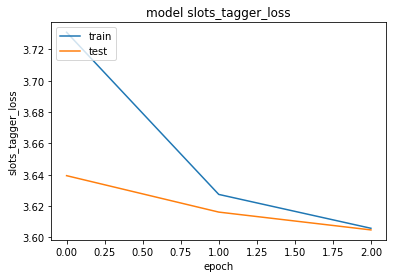

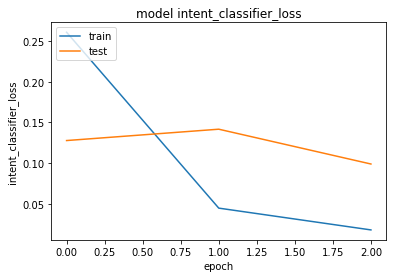

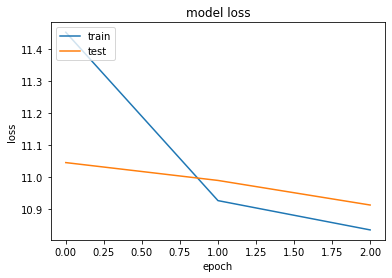

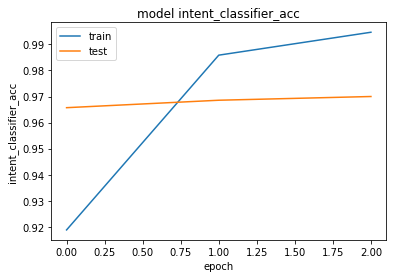

In [5]:
# start model training
nlu.train(train_dataset, val_dataset, epochs=3, batch_size=32)

## Save the trained model
Save the full model and convert it to `tflite` model with `hybrid_quantization`

In [6]:
save_path = f"../saved_models/joint_{pretrained_model}_model_pruning_{k_layers}_layers"

print(f"Saving model to '{save_path}' ...")
nlu.save(save_path, save_tflite=True, conversion_mode="hybrid_quantization")
print("Saved!")

Saving model to '../saved_models/joint_distilbert-base-uncased_model_pruning_4_layers' ...


INFO:tensorflow:Assets written to: /tmp/tmpm769he17/assets


INFO:tensorflow:Assets written to: /tmp/tmpm769he17/assets
INFO:absl:Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False


Saved!


## [Optional] Load the model from disk

In [7]:
print("Loading model ...")
nlu = AutoNLU.load(save_path)

Loading model ...
Loading TransformerNLU ...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 38011392    input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 64, 73)   

## Reading Testing Dataset

In [8]:
test_path = "../data/snips/test" # please, specify the path to the testing dataset
test_dataset = Reader.read(test_path)

## Evaluating model

In [9]:
token_f1_score, tag_f1_score, report, acc = nlu.evaluate(test_dataset)

print('Slot Classification Report:', report)
print('Slot token f1_score = %f' % token_f1_score)
print('Slot tag f1_score = %f' % tag_f1_score)
print('Intent accuracy = %f' % acc)

Vectorizing validation text ...


/home/mwahdan/anaconda3/envs/nlp_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['input_type_ids', 'sequence_lengths'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Slot Classification Report:                             precision    recall  f1-score   support

                     album     0.0000    0.0000    0.0000        10
                    artist     0.3440    0.4019    0.3707       107
               best_rating     1.0000    1.0000    1.0000        43
                      city     0.3646    0.5833    0.4487        60
     condition_description     0.9655    1.0000    0.9825        28
     condition_temperature     1.0000    1.0000    1.0000        23
                   country     0.6136    0.6136    0.6136        44
                   cuisine     0.8889    0.5714    0.6957        14
          current_location     0.8667    0.9286    0.8966        14
               entity_name     0.2031    0.3939    0.2680        33
                  facility     1.0000    1.0000    1.0000         3
                     genre     0.6000    0.6000    0.6000         5
            geographic_poi     0.0455    0.0909    0.0606        11
             locati

## Make Predictions

In [10]:
l = widgets.Layout(flex='0 1 auto', height='40px', min_height='30px', width='auto')
utterance_txt = widgets.Textarea(
    value='add sabrina salerno to the grime instrumentals playlist',
    placeholder='Type utterance here!',
    description='Utterance:',
    layout=l,
    disabled=False
)

predict_btn = widgets.Button(
    description='Predict'
)

result_layout = widgets.Layout(flex='0 1 auto', height='400px', min_height='30px', width='auto')
result_txt = widgets.Textarea(
    value='',
    placeholder='Result goes here',
    description='Result:',
    layout=result_layout,
    disabled=True
)


def btn_click_event(x):
    result = nlu.predict(utterance_txt.value)
    result = json.dumps(result, indent=4, sort_keys=True)
    result_txt.value = result
    
predict_btn.on_click(btn_click_event)
display(utterance_txt, predict_btn, result_txt)


Textarea(value='add sabrina salerno to the grime instrumentals playlist', description='Utterance:', layout=Lay…

Button(description='Predict', style=ButtonStyle())

Textarea(value='', description='Result:', disabled=True, layout=Layout(flex='0 1 auto', height='400px', min_he…